# Introduction

This notebook contains the final dataset and all data cleaning and preprocessing steps. After data cleaning, it shows EDA, and statistical tests.

# Using this notebook

You will need to use the data for development, not production (smaller dataset) as the production dataframe is too large for the GitHub repo. The `dev_df` csv file is located in the `lyft_no_data` folder (the project's repository folder. Change the directories in the `pd.read_csv` calls to point to this file and everything should run.

# Table of contents


1.   Initial Setup
2.   Data Cleaning / Preprocessing
3.   Exploratory Data Analysis (EDA)
4.   Data story / synthesis
5.   Statistical tests
6.   Machine Learning / Modeling -- Coming soon


# Initial Setup

In [0]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
# Read in the dataset
dev_df = pd.read_csv('/content/SF_DF.csv')

# joining the regions df so that I can filter by SF region

regions = pd.read_csv('/content/region_ids.csv')

dev_df = pd.merge(dev_df, regions, 'inner', left_on='start_station_id', right_on='station_id')

# Data Cleaning / Preprocessing

In [0]:
# first things first, filter the master df down to SF region to simplify things:

dev_df = dev_df[dev_df['region_id'] == 3]

# Convert times to datetime
dev_df['start_time'] = pd.to_datetime(dev_df['start_time'])
dev_df['end_time'] = pd.to_datetime(dev_df['end_time'])

# Get the day of the rides too
dev_df['day_of_ride'] = dev_df['start_time'].apply(lambda x: x.day)

In [0]:
# Remove member_birth_year
dev_df.drop('member_birth_year', axis=1, inplace=True)

In [0]:
# Remove the 31st day since it's not in every month
dev_df = dev_df[dev_df['day_of_ride'] < 31]

# EDA

The purpose of this section is to get started on the EDA unit of DSC on my dev df. I still need to crunch the whole df, but by the time I do that I'll have "finished" EDA, or at least I'll know what plots I will want.

### General questions to explore

Some questions I'll be exploring in this notebook in turn include:

1. What is the general distribution of variables? When I see this, are there any more outliers to account for?

2. Looking at bivariate data, what are the distributions of age by gender for example?

3. What is the correlation between cost per ride and duration of rides? How are costs and durations distributed?

4. Is there patterning in the bikes that are most vs. least profitable?

5. Is there a relationship between cost, ride length, and gender? User type?

6. How can I visualize the data on maps?

### Questions to analyze further and business cases for analyzing them:

1. Given a departure station, what is the revenue from the individual ride? Reason: to learn what the most profitable stations are to look into increasing funding, bike supply, etc. at that/those stations.

2. Given a rider's age and gender, how likely are they to do an above average value ride. Reason: target marketing campaigns towards consumers who match that demographic to increase revenue.

3. What is the most popular time of day and day of week to ride the bikes? Reason: campaigns and push notifications can be used for on subscribers to encourage them to take a bike. After this, you can do an A/B test to measure the efficacy of those efforts (i.e. did ridership increase after implementing these? If so, is it due to random chance or not [statistical test]?)

#### 1. What is the general distribution of variables? When I see this, are there any more outliers to account for?

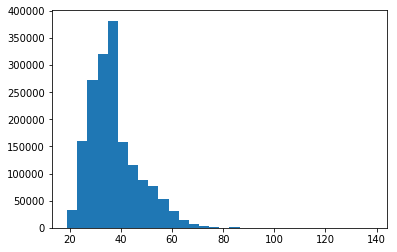

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

plt.hist(dev_df['age'], bins=30);

Based on the histogram above, I've decided to remove values >= 100

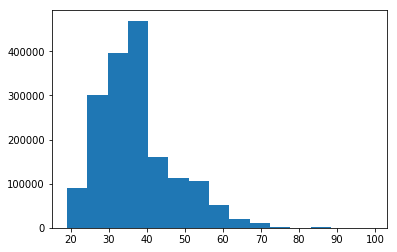

In [8]:
# simplify the name of the df
dev_df = dev_df[dev_df['age'] < 100]

import matplotlib.pyplot as plt
%matplotlib inline

age = dev_df['age']

plt.hist(x=age, bins = 15);

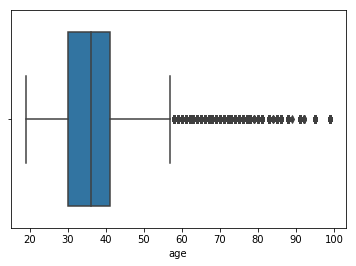

In [9]:
import seaborn as sns

sns.boxplot(age);

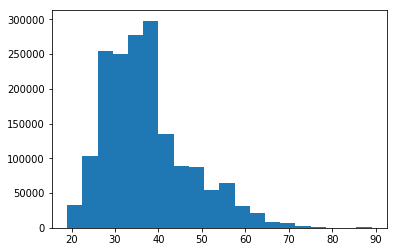

In [10]:
dev_df = dev_df[dev_df['age'] < 90]

age = dev_df['age']

plt.hist(x=age, bins = 20);
plt.show()

Honestly I could cut this down to a max age of 75, it doesn't really matter - bikesharing is such a milennial thing.

#### 2. Looking at bivariate data, what are the distributions of age by gender for example?

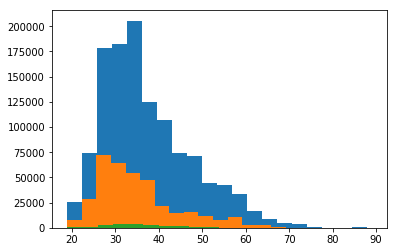

In [11]:
# take a look at the distribution by gender below

men = dev_df[dev_df['member_gender'] == 0.0]['age']
women = dev_df[dev_df['member_gender'] == 1.0]['age']
other = dev_df[dev_df['member_gender'] == 2.0]['age']

plt.hist(x=men, bins = 20)
plt.hist(x=women, bins = 20)
plt.hist(x=other, bins = 20)
plt.show();

#### 3. What is the correlation between cost per ride and duration of rides? How are costs and durations distributed?

In [0]:
mins = dev_df['duration_min']

dev_df['start_time'] = pd.to_datetime(dev_df['start_time'])
dev_df['end_time'] = pd.to_datetime(dev_df['end_time'])

start_hours = dev_df['start_time'].apply(lambda x: x.hour)

end_hours = dev_df['end_time'].apply(lambda x: x.hour)

days = dev_df['end_time'].apply(lambda x: x.day)

days_list = days.value_counts(ascending=True).index.tolist()

counts = days.value_counts(ascending=True).tolist()

d= {'days':days_list,
    'counts':counts}

day_counts = pd.DataFrame(d)

day_counts = day_counts.sort_values(['days'])

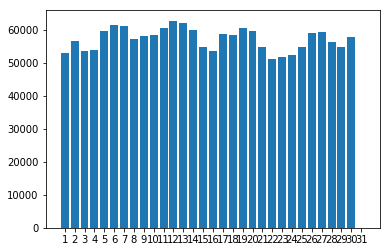

In [13]:
plt.bar(x=day_counts.days, height=day_counts.counts);
plt.xticks(day_counts.days.to_list());

There's an interesting cyclic pattern in that the peaks are around the beginning of weeks, with higher peaks progressively through the month and the max number of rides being at the end.

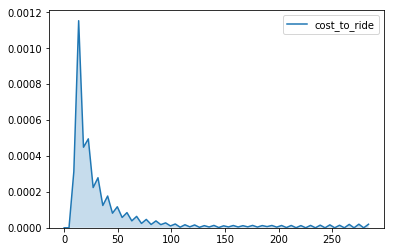

In [14]:
sns.kdeplot(dev_df['cost_to_ride'], shade=True, gridsize=40)

The cost of rides is left skewed too and most rides are under 50 or even 10 dollars.

#### 5. Is there patterning in the bikes that are most vs. least profitable?

In [15]:
# pivot and melt:
bike_revenue = dev_df.pivot_table(values='cost_to_ride', columns='bike_id', aggfunc='sum').melt()

# sorted best performer to least performer
bike_revenue = bike_revenue.sort_values('value', ascending=False)
bike_revenue[:10]

,bike_id,value
869,1112,2044
2320,2852,2038
2638,3235,2026
52,73,1962
2297,2829,1922
2235,2766,1878
2029,2543,1868
978,1298,1866
2425,2970,1864
442,579,1835


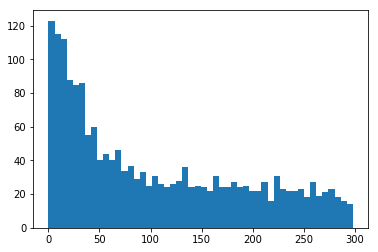

In [16]:
# There are not many bikes that make more than $300 so filtering down here

bike_revenue = bike_revenue[bike_revenue['value'] < 300]

# distribution of value by bike
plt.hist(bike_revenue.value, bins=50);

In [17]:
#bike 3328 has accrued the most value

bike_revenue[bike_revenue['value'] > 250][:10].sort_values('value', ascending=False)

,bike_id,value
3328,4424,298
1781,2264,298
3118,4000,298
239,288,296
737,932,296
727,918,296
1549,2015,296
1471,1933,296
3220,4305,295
2076,2591,295


### More data viz and mapping

#### 6. Is there a relationship between cost, ride length, and gender? User type?

In [0]:
men = dev_df[dev_df['member_gender'] == 0.0]
women = dev_df[dev_df['member_gender'] == 1.0]
other = dev_df[dev_df['member_gender'] == 2.0]

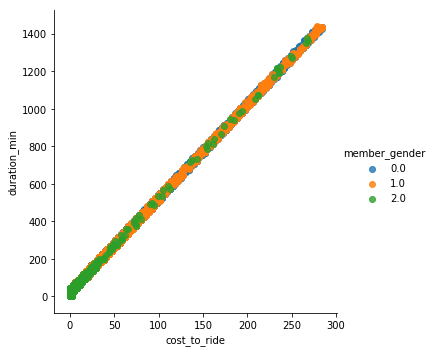

In [19]:
# plotting cost and duration colored by gender
sns.lmplot(x='cost_to_ride', y='duration_min', hue='member_gender', data=dev_df, fit_reg=False)

Naturally duration of ride and cost are very correlated, but interestingly we see a bunching of lower cost and shorter rides for gender Female and Other (1 and 2 respectively).

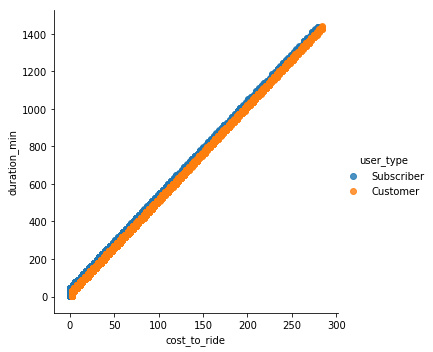

In [20]:
# cost and duration colored by user type
sns.lmplot(x='cost_to_ride', y='duration_min', hue='user_type', data=dev_df, fit_reg=False)

It doesn't seem like there are any differecnces really between subscribers and customers.

#### 7. Map visualizations

In [21]:
import folium # Use the Folium Javascript Map Library
import folium.plugins

# for some reason folium doesn't work for more than 66000 data points, so I will sample for now and that'll work in a pinch
sample = dev_df[:4000]

SF_COORDINATES = (37.77, -122.35)
sf_map = folium.Map(location=SF_COORDINATES, zoom_start=11)
locs = sample[['end_station_latitude', 'end_station_longitude']].astype('float').dropna().as_matrix()
heatmap = folium.plugins.HeatMap(locs.tolist(), radius = 10)
sf_map.add_child(heatmap)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if __name__ == '__main__':


Here's the locations of the end stations for each ride.

# Stats Tests

The purpose of this section is to look into statistical significance, hypothesis tests, and tests to verify that the empirical distributions match or don't match the theoretical distributions I see these variables as.

I'll perform the following steps:

1. A little more EDA as needed and data cleaning that results from that

2. Joining the region IDs and filtering down as I've done for the master DF

3. Bootstrap resampling on various discrete and continuous variables to see that my samples reasonably came from the population.

4. Bayesian tests as necessary.

In [0]:
# Get revenue by station

station_revenue = dev_df.pivot_table(values='cost_to_ride', columns='start_station_id', aggfunc='sum').melt()

station_revenue['total_value_of_station'] = station_revenue['value']

station_revenue.drop('value', axis=1, inplace=True)

dev_df = dev_df.merge(station_revenue, 'inner', left_on='start_station_id', right_on='total_value_of_station')

In [0]:
from sklearn.utils import resample

# making necessary bootstrap functions to use over and over

def bootstrap_sample(var, func=np.mean, repetitions=10000, conf_interval=[2.5, 97.5]):
    test_stat = func(var)
    
    var_name = str(var)
    func_name = str(func)
    
    repetitions = repetitions
    
    variables = np.empty(repetitions)
    
    for i in range(repetitions):
        variables[i] = func(resample(var, n_samples = repetitions))
    
    lower_conf, upper_conf = np.percentile(variables, conf_interval)

    return print(f"Test stat = {test_stat}"), print('\n'), print(f"Confidence interval is between {lower_conf} and {upper_conf}"), plt.hist(variables), plt.title("Bootstrap resample of test stat"), plt.xlabel("Possible test stat values"), plt.ylabel("Count")#, plt.axvline(test_stat, color='y'), plt.axvline(conf_interval[0], color='y', linestyle='--'), plt.axvline(conf_interval[1], color='y', linestyle='--'), plt.show()

Test stat = 11.848288770053475


Confidence interval is between 11.286187499999999 and 12.4912225


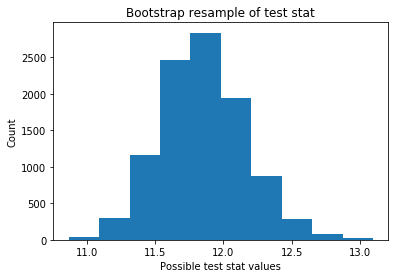

In [24]:
# duration of rides
bootstrap_sample(dev_df.duration_min, repetitions=10000);

Test stat = 36.10267379679144


Confidence interval is between 35.9447975 and 36.264405000000004


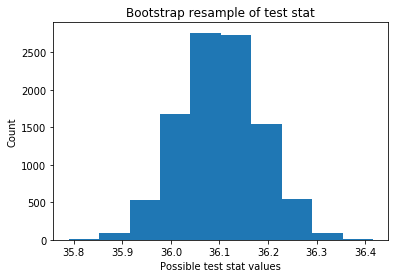

In [25]:
# mean age
bootstrap_sample(dev_df.age);

Test stat = 0.5408823529411765


Confidence interval is between 0.4348975 and 0.6639


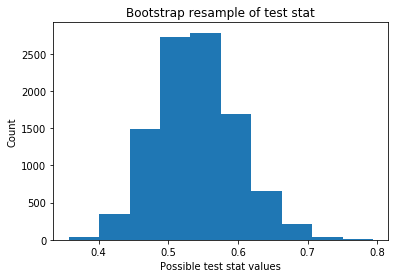

In [26]:
bootstrap_sample(dev_df.cost_to_ride);

### Bootstrap Resampling of standard deviation differences
Checking the difference between subscriber and customer cost of ride standard deviations

In [0]:
def std_diff(data_1, data_2):
    """Difference in means of two arrays."""

    # The difference of std of data_1, data_2: diff
    diff = np.std(data_1) - np.std(data_2)

    return diff

def permute_sample(data1, data2):
    """Generate a permutation sample from two data sets."""

    # Concatenate the data sets: data
    data = np.concatenate((data1, data2)) # tuple

    # Permute the concatenated array: permuted_data
    permuted_data = np.random.permutation(data)

    # Split the permuted array into two: perm_sample_1, perm_sample_2
    perm_samp_1 = permuted_data[:len(data1)]
    perm_samp_2 = permuted_data[len(data1):]

    return perm_samp_1, perm_samp_2

def draw_perm_reps(data_1, data_2, func, size=1):
    """Generate multiple permutation replicates."""

    # Initialize array of replicates: perm_replicates
    perm_replicates = np.empty(size)

    for i in range(size):
        # Generate permutation sample
        perm_samp_1, perm_samp_2 = permute_sample(data_1, data_2)

        # Compute the test statistic
        perm_replicates[i] = func(perm_samp_1, perm_samp_2)

    return perm_replicates

In [28]:
# split the data up by subscriber and customer
subscribers = dev_df[dev_df['user_type'] == 'Subscriber'].cost_to_ride
customers = dev_df[dev_df['user_type'] == 'Customer'].cost_to_ride

subscribers_std = np.std(subscribers)
customers_std = np.std(customers)

print(f'std for subscribers = {subscribers_std}, std for customers = {customers_std}')

std for subscribers = 3.418770872590491, std for customers = 15.41654025055821


In [0]:
N_rep = 1000
 
bs_sample_std_diff = np.empty(N_rep)    
 
# Generate bootstrap sample: bs_sample
bs_sample_std_diff = draw_perm_reps(subscribers, customers, std_diff, N_rep)

Standard deviation mean diff: 0.16174539848751238
95% percentile: lower -3.0823812407736004, upper 3.3896121018721472


/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


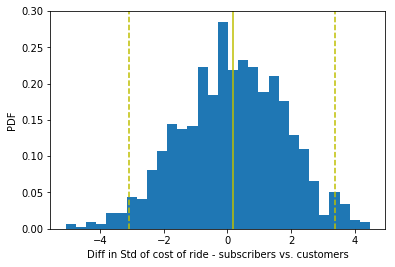

In [30]:
import matplotlib.pyplot as plt
%matplotlib inline

bs_sample_std_diff = np.sort(bs_sample_std_diff)
bs_sample_std_mean = np.mean(bs_sample_std_diff)

bs_sample_std_perc_95 = np.percentile(bs_sample_std_diff, [2.5, 97.5])
print('Standard deviation mean diff: ' + str(bs_sample_std_mean))
print('95% percentile: lower ' + str(bs_sample_std_perc_95[0]) + ', upper ' + str(bs_sample_std_perc_95[1]))
_ = plt.hist(bs_sample_std_diff, bins=30, normed=True)
_ = plt.xlabel('Diff in Std of cost of ride - subscribers vs. customers')
_ = plt.ylabel('PDF')
_ = plt.axvline(bs_sample_std_mean, color='y')
_ = plt.axvline(bs_sample_std_perc_95[0], color='y', linestyle='--') 
_ = plt.axvline(bs_sample_std_perc_95[1], color='y', linestyle='--') 
plt.show()

H0 = there is a difference between the standard deviations of cost to ride for customers vs. subscribers
H1 = there is no difference between the standard deviations of cost to ride for customers vs. subscribers

95% confidence interval is -7 to 7.97 standard deviation, so we lack sufficient evidence to state H0 that there is a difference, and thus reject the null hypothesis, meaning that the mean standard deviation of the cost to ride for customers and subscribers is within the confidence interval range and thus is unlikely to have been observed by random chance. 

In [57]:
dev_df.columns

Index(['Unnamed: 0_x', 'bike_id', 'end_station_id', 'end_station_latitude',
       'end_station_longitude', 'end_time', 'member_gender',
       'start_station_id_x', 'start_station_latitude',
       'start_station_longitude', 'start_time', 'user_type', 'Unnamed: 0.1',
       'station_id_x', 'duration_min', 'age', 'cost_to_ride', 'day_of_ride',
       'Unnamed: 0_y', 'names', 'station_id_y', 'region_id',
       'start_station_id_y', 'total_value_of_station'],
      dtype='object')

In [69]:
ML_df = dev_df[['user_type', 'age', 'member_gender', 'duration_min']]

types = {'Customer': 0, 'Subscriber':1}

# Use replace to replace each key in genders dict with corresponding value
ML_df['user_type'].replace(types, inplace=True);

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:6586: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [74]:
# had to do it, I only lose 200 rows of gender info
ML_df.dropna(how='any', inplace=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [75]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

X = ML_df.iloc[:, :-1]

y = ML_df['duration_min']

# Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

# Create the regressor: reg_all
reg_all = LinearRegression()

# Fit the regressor to the training data
reg_all.fit(X_train, y_train)

# Predict on the test data: y_pred
y_pred = reg_all.predict(X_test)

# Compute and print R^2 and RMSE
print("R^2: {}".format(reg_all.score(X_test, y_test)))
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error: {}".format(rmse))

R^2: 0.009073423056008778
Root Mean Squared Error: 24.656955664440336


R squared is almost non-existent but the Root Mean Squared Error is pretty good.

In [76]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

# Create a linear regression object: reg
reg = LinearRegression()

# Compute 5-fold cross-validation scores: cv_scores
cv_scores = cross_val_score(reg, X, y, cv=5)

# Print the 5-fold cross-validation scores
print(cv_scores)

# Print the average 5-fold cross-validation score
print("Average 5-Fold CV Score: {}".format(np.mean(cv_scores)))

[-0.00067336  0.01795258 -0.00019745  0.0021323   0.00336142]
Average 5-Fold CV Score: 0.004515098954770735
